# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime
from dateutil.relativedelta import relativedelta
import MyFinTechLib as ft

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# Initialize variables and CONSTANTS
TRADING_DAYS = ft.TRADING_DAYS

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price in CAD
btc_resp = requests.get(btc_url)
btc_price = btc_resp.json()['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
eth_resp = requests.get(eth_url)
eth_price = eth_resp.json()['data']['1027']['quotes']['CAD']['price']

# Calculate USD to CAD conversion rate
btc_price_usd = btc_resp.json()['data']['1']['quotes']['USD']['price']
cad_to_usd = btc_price / btc_price_usd

# Create function to convert USD to CAD. This is SPECIFIC to our use case!
def conv_usd_to_cad(alpacas_df, cad_to_usd_rate):
    alpacas_df[['open','high','low','close','vwap']] = alpacas_df[['open','high','low','close','vwap']] * cad_to_usd_rate

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")
print(f"The conversion rate of USD to CAD is {cad_to_usd}")

The current value of your 1.2 BTC is $45696.14
The current value of your 5.3 ETH is $12821.27
The conversion rate of USD to CAD is 1.3585


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key=os.getenv('APCA_API_KEY_ID')
alpaca_secret_key=os.getenv('APCA_API_SECRET_KEY')
alpaca_endpoint=os.getenv('APCA_API_BASE_URL')

# Create the Alpaca API object
alpaca = tradeapi.REST()

In [9]:
# Format current date as ISO format
date = datetime.date.today()
date_fmt = date.strftime('%Y-%m-%d')
today = pd.Timestamp(date_fmt, tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
# The current day may be a day when the markets are closed (weekend, holiday, etc.)
# So, if the retrieved portfolio is empty, let's try the previous day.
portfolio_df = alpaca.get_bars(tickers, timeframe, start=today, end=today).df

while portfolio_df.empty:
    date -= relativedelta(days=1)
    date_fmt = date.strftime('%Y-%m-%d')
    today = pd.Timestamp(date_fmt, tz='America/New_York').isoformat()
    portfolio_df = alpaca.get_bars(tickers, timeframe, start=today, end=today).df

# Convert all USD to CAD
conv_usd_to_cad(portfolio_df, cad_to_usd)

# Reorganize the DataFrame
# Separate ticker data
ticker_data_list=[portfolio_df[portfolio_df['symbol'] == ticker].drop('symbol', axis='columns') for ticker in tickers]

# Concatenate the ticker DataFrames
ticker_df = pd.concat(ticker_data_list, axis='columns', join='inner', keys=tickers)

# Preview DataFrame
ticker_df

AGG                                     \
                                open        high         low      close   
timestamp                                                                 
2023-03-24 04:00:00+00:00  136.23038  136.515665  135.782075  136.06736   

                                                                   SPY  \
                            volume trade_count        vwap        open   
timestamp                                                                
2023-03-24 04:00:00+00:00  6203977       23905  136.047863  532.315998   

                                                                       \
                                high       low       close     volume   
timestamp                                                               
2023-03-24 04:00:00+00:00  537.74864  528.9999  537.626375  107053295   

                                                   
                          trade_count        vwap  
timestamp                                          
2023-03-24 04:00:00+00:00      801995  534.040902

In [10]:
# Pick AGG and SPY close prices
agg_close_price = float(ticker_df['AGG']['close'])
spy_close_price = float(ticker_df['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $136.06736
Current SPY closing price: $537.626375


In [11]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $26881.32
The current value of your 200 AGG shares is $27213.47


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_total = my_btc_value + my_eth_value
shares_total = my_spy_value + my_agg_value
inv_types = ['crypto', 'shares']
inv_totals = {'amount': [crypto_total, shares_total]}

# Create savings DataFrame
df_savings = pd.DataFrame(inv_totals, index=inv_types)

# Display savings DataFrame
display(df_savings)

,amount
crypto,58517.409236
shares,54094.790750


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

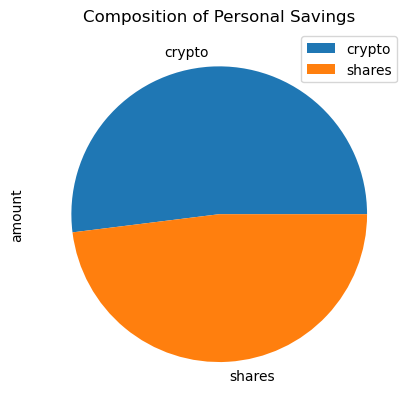

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', title='Composition of Personal Savings')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum()

# Validate saving health
savings_goal = float(total_savings - emergency_fund)

if savings_goal > 0:
    print('Congratulations! You have enough money in your emergency fund.')
elif savings_goal < 0:
    print(f'Keep going! You have ${savings_goal} to go to meet your goal.')
else:
    print('Congratulations! You have reached your goal.')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
five_yrs_ago=date-relativedelta(years=5)
five_yrs_ago = five_yrs_ago.strftime('%Y-%m-%d')

start_date = pd.Timestamp(five_yrs_ago, tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
portfolio_5yr_df = alpaca.get_bars(tickers, timeframe, start=start_date, end=today).df

# Convert USD to CAD
conv_usd_to_cad(portfolio_5yr_df, cad_to_usd)
# Reorganize the DataFrame
# Separate ticker data
stock_data_list = [portfolio_5yr_df[portfolio_5yr_df['symbol'] == ticker].drop('symbol', axis='columns') for ticker in tickers]

# Concatenate the ticker DataFrames
df_stock_data = pd.concat(stock_data_list, axis='columns', join='inner', keys=tickers)

# Display sample data
df_stock_data.head()

AGG                                      \
                                 open        high         low       close   
timestamp                                                                   
2018-03-26 04:00:00+00:00  144.870440  144.965535  144.639495  144.775345   
2018-03-27 04:00:00+00:00  144.856855  145.291575  144.829685  145.196480   
2018-03-28 04:00:00+00:00  145.427425  145.495350  145.196480  145.277990   
2018-03-29 04:00:00+00:00  145.291575  145.712710  145.291575  145.699125   
2018-04-02 04:00:00+00:00  145.223650  145.413840  145.114970  145.223650   

                                                                   SPY  \
                            volume trade_count        vwap        open   
timestamp                                                                
2018-03-26 04:00:00+00:00  4546535       19722  144.794175  356.103605   
2018-03-27 04:00:00+00:00  4566884       14293  145.123188  361.591945   
2018-03-28 04:00:00+00:00  5617206       18689  145.329794  354.228875   
2018-03-29 04:00:00+00:00  9199453       20364  145.648727  354.731520   
2018-04-02 04:00:00+00:00  7280259       24906  145.261192  356.674175   

                                                                          \
                                 high         low       close     volume   
timestamp                                                                  
2018-03-26 04:00:00+00:00  360.586655  352.408485  360.192690  143141239   
2018-03-27 04:00:00+00:00  362.407045  351.634140  354.242460  130806695   
2018-03-28 04:00:00+00:00  356.796440  351.280930  353.006225  146510333   
2018-03-29 04:00:00+00:00  360.355710  352.991146  357.869655  125470572   
2018-04-02 04:00:00+00:00  357.462105  345.969195  349.840920  186324337   

                                                   
                          trade_count        vwap  
timestamp                                          
2018-03-26 04:00:00+00:00      450168  356.406700  
2018-03-27 04:00:00+00:00      538201  357.483553  
2018-03-28 04:00:00+00:00      590467  353.747537  
2018-03-29 04:00:00+00:00      436558  357.061600  
2018-04-02 04:00:00+00:00      643544  350.781003

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Using 60% stocks (SPY), 40% bonds (AGG), 500 runs
MC_30yr_cumret = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4, 0.6],
    num_simulation = 500,
    num_trading_days = TRADING_DAYS * 30
)

In [18]:
# Printing the simulation input data
MC_30yr_cumret.portfolio_data.head()

AGG                                      \
                                 open        high         low       close   
timestamp                                                                   
2018-03-26 04:00:00+00:00  144.870440  144.965535  144.639495  144.775345   
2018-03-27 04:00:00+00:00  144.856855  145.291575  144.829685  145.196480   
2018-03-28 04:00:00+00:00  145.427425  145.495350  145.196480  145.277990   
2018-03-29 04:00:00+00:00  145.291575  145.712710  145.291575  145.699125   
2018-04-02 04:00:00+00:00  145.223650  145.413840  145.114970  145.223650   

                                                                         \
                            volume trade_count        vwap daily_return   
timestamp                                                                 
2018-03-26 04:00:00+00:00  4546535       19722  144.794175          NaN   
2018-03-27 04:00:00+00:00  4566884       14293  145.123188     0.002909   
2018-03-28 04:00:00+00:00  5617206       18689  145.329794     0.000561   
2018-03-29 04:00:00+00:00  9199453       20364  145.648727     0.002899   
2018-04-02 04:00:00+00:00  7280259       24906  145.261192    -0.003263   

                                  SPY                                      \
                                 open        high         low       close   
timestamp                                                                   
2018-03-26 04:00:00+00:00  356.103605  360.586655  352.408485  360.192690   
2018-03-27 04:00:00+00:00  361.591945  362.407045  351.634140  354.242460   
2018-03-28 04:00:00+00:00  354.228875  356.796440  351.280930  353.006225   
2018-03-29 04:00:00+00:00  354.731520  360.355710  352.991146  357.869655   
2018-04-02 04:00:00+00:00  356.674175  357.462105  345.969195  349.840920   

                                                                           
                              volume trade_count        vwap daily_return  
timestamp                                                                  
2018-03-26 04:00:00+00:00  143141239      450168  356.406700          NaN  
2018-03-27 04:00:00+00:00  130806695      538201  357.483553    -0.016520  
2018-03-28 04:00:00+00:00  146510333      590467  353.747537    -0.003490  
2018-03-29 04:00:00+00:00  125470572      436558  357.061600     0.013777  
2018-04-02 04:00:00+00:00  186324337      643544  350.781003    -0.022435

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr_cumret.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rafinazamodeen/Development/bootcamp/module5_financial_planning/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991609,0.988447,0.998750,1.005210,0.998032,0.991186,0.995202,0.994773,1.003187,0.998813,...,1.006995,1.000009,1.011846,0.985798,1.012265,0.990835,1.003040,1.014012,1.005764,0.986567
2,0.991695,0.989993,0.992529,0.996593,1.005585,0.995778,0.990660,0.991019,0.997481,1.002314,...,1.009759,1.002797,1.008984,0.982149,1.007387,0.978031,1.016280,1.018056,1.008503,0.986871
3,0.987437,0.999092,0.999234,1.015013,1.013898,1.009040,0.985627,1.002085,0.998459,0.991390,...,1.003564,1.001082,1.022353,0.968592,1.017202,0.980715,1.033488,1.013252,1.018234,0.995310
4,0.973033,1.008014,1.004419,1.020956,1.015364,1.013174,0.989010,1.000545,0.999439,1.001872,...,0.995746,0.997130,1.016059,0.970279,1.023741,0.993935,1.029417,1.007399,1.020989,0.990195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.116130,2.602703,6.149875,9.481574,5.051968,4.588616,12.202027,3.533952,3.425547,2.003871,...,9.057031,1.387766,2.220185,2.581527,5.934977,23.370116,1.665274,6.685505,2.724225,1.210153
7557,4.097293,2.620144,6.087802,9.496101,5.033470,4.619609,12.150049,3.581794,3.422345,1.998966,...,9.039178,1.390407,2.238857,2.573010,5.904961,23.306892,1.709010,6.739482,2.736651,1.224967
7558,4.158033,2.615210,6.025022,9.478533,5.007150,4.586527,12.178984,3.566289,3.382293,2.028885,...,8.972451,1.385714,2.234491,2.593693,5.914867,23.123368,1.695058,6.707488,2.789377,1.218271
7559,4.148619,2.645771,5.943947,9.497476,4.977329,4.538051,11.963807,3.589924,3.381698,2.060733,...,9.008787,1.364417,2.231445,2.619697,5.972581,23.352292,1.677508,6.666028,2.769648,1.210367


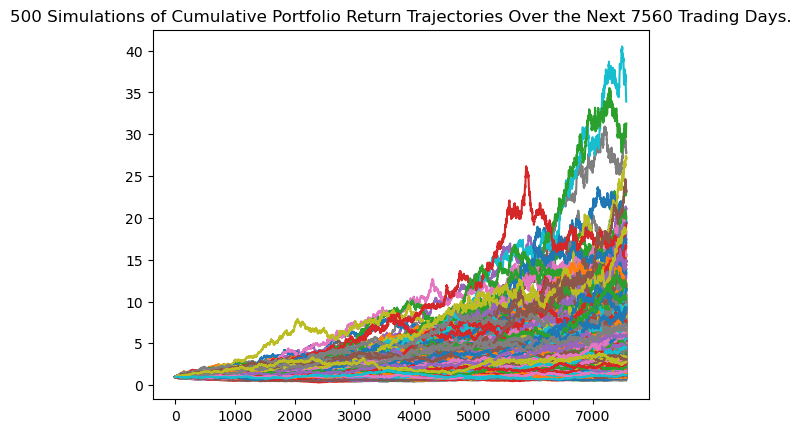

In [20]:
# Plot simulation outcomes
MC_30yr_cumret_line_plot = MC_30yr_cumret.plot_simulation()

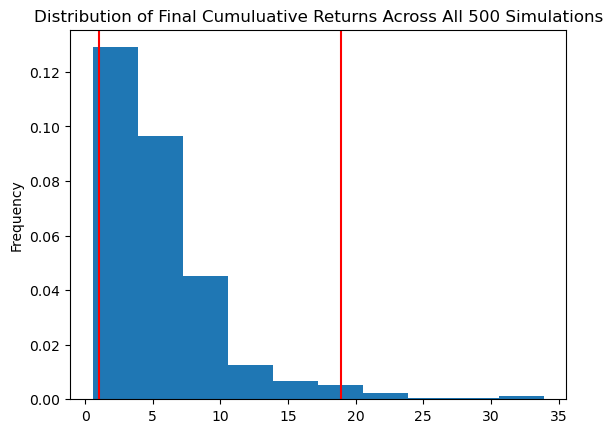

In [21]:
# Plot probability distribution and confidence intervals
MC_30yr_cumret_dist_plot = MC_30yr_cumret.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_30yr_cumret_tbl = MC_30yr_cumret.summarize_cumulative_return()

# Print summary statistics
MC_30yr_cumret_tbl

count           500.000000
mean              5.613456
std               4.520073
min               0.562264
25%               2.632551
50%               4.360958
75%               7.175756
max              33.902578
95% CI Lower      1.045513
95% CI Upper     18.904921
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_30yr_cumret_tbl[8]*initial_investment, 2)
ci_upper = round(MC_30yr_cumret_tbl[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $20910.25 and $378098.42


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_30yr_cumret_tbl[8]*initial_investment, 2)
ci_upper = round(MC_30yr_cumret_tbl[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $31365.38 and $567147.64


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# Since the initial amount invested didn't seem to affect the outcome 30 years later,
# we'll change the weighting for more stocks. Intuitively, more risk over a shorter 
# period of time should be acceptable.

MC_5yr_early_cumret = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[0.4,0.6],
    num_simulation=500,
    num_trading_days= TRADING_DAYS*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5yr_early_cumret.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rafinazamodeen/Development/bootcamp/module5_financial_planning/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005869,1.000861,0.990437,0.984977,1.005843,0.990114,1.001514,0.999001,1.009234,0.995081,...,0.992444,0.987584,1.018687,0.998952,1.007200,1.014127,1.000328,1.000621,1.005677,0.987842
2,1.011864,1.005111,0.981498,0.988432,0.992357,0.986383,1.000243,1.001465,1.013658,1.006696,...,1.001660,0.992116,1.016814,0.993390,1.017898,1.000914,1.001969,0.994936,0.999581,0.989708
3,1.010365,1.008829,0.962340,0.993847,0.990562,0.989810,1.000936,1.008628,1.011815,0.988130,...,1.003420,0.980587,0.997756,0.990544,1.023208,1.004739,1.012466,1.004357,0.999766,0.997949
4,1.009458,1.016288,0.967992,0.994199,0.993569,1.001266,1.001098,1.009327,1.013280,0.980978,...,1.005101,0.976186,1.002636,0.988957,1.034441,0.996091,1.025219,0.999189,1.001473,0.997915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.047737,1.223014,1.329531,1.366433,1.291501,1.536363,2.015436,0.864101,1.479974,1.391196,...,1.204984,1.331569,2.093571,1.385879,1.477479,1.174645,1.558557,1.352564,0.724497,1.516637
1257,1.061466,1.226519,1.318121,1.361671,1.306339,1.544516,2.014329,0.862855,1.481712,1.387499,...,1.218105,1.335540,2.096069,1.395686,1.488564,1.182569,1.552482,1.358484,0.727394,1.502077
1258,1.066929,1.238784,1.314418,1.361617,1.288075,1.557006,2.002016,0.873199,1.485017,1.398003,...,1.230386,1.350337,2.111898,1.383278,1.496707,1.201585,1.553774,1.364010,0.727158,1.489674
1259,1.065427,1.254344,1.315511,1.381567,1.309156,1.549304,2.001456,0.875902,1.480104,1.371240,...,1.247057,1.330481,2.097885,1.381847,1.486769,1.216679,1.554923,1.372006,0.723005,1.483653


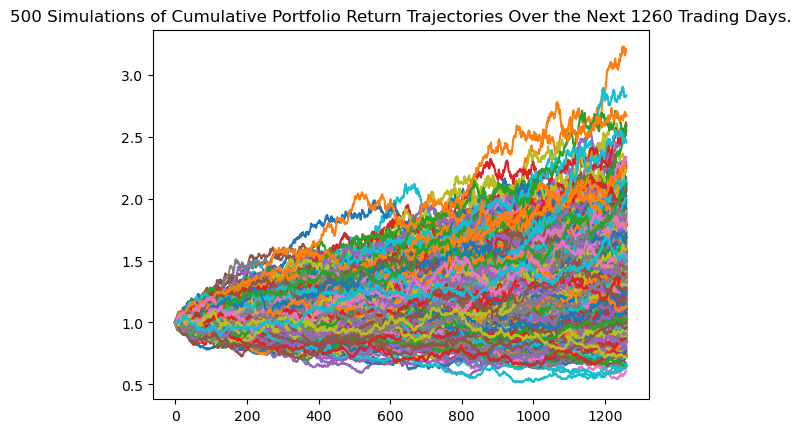

In [27]:
# Plot simulation outcomes
MC_5yr_early_cumret_line_plot = MC_5yr_early_cumret.plot_simulation()

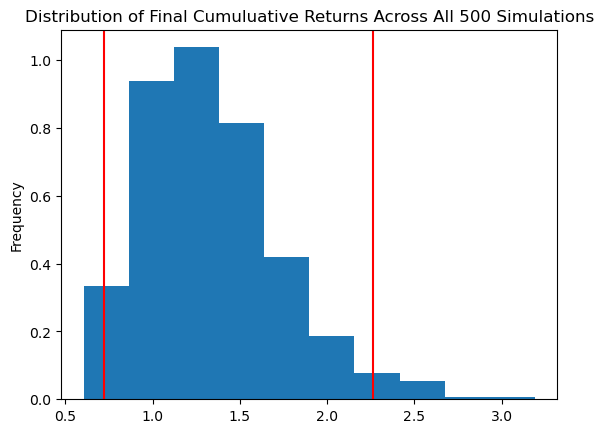

In [28]:
# Plot probability distribution and confidence intervals
MC_5yr_early_cumret_dist_plot = MC_5yr_early_cumret.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_5yr_early_cumret_tbl = MC_5yr_early_cumret.summarize_cumulative_return()

# Print summary statistics
MC_5yr_early_cumret_tbl

count           500.000000
mean              1.341103
std               0.396460
min               0.606558
25%               1.061956
50%               1.293962
75%               1.538552
max               3.190231
95% CI Lower      0.722181
95% CI Upper      2.265030
Name: 1260, dtype: float64

In [30]:
# Set initial investment
initial_investment = 30000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(MC_5yr_early_cumret_tbl[8] * initial_investment, 2)
ci_upper_five = round(MC_5yr_early_cumret_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 5 years will end within in the range of $21665.43 and $67950.9


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10yr_early_cumret = MCSimulation(
    portfolio_data=df_stock_data,
    weights=[0.4,0.6],
    num_simulation=500,
    num_trading_days= TRADING_DAYS*10
)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10yr_early_cumret.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rafinazamodeen/Development/bootcamp/module5_financial_planning/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003029,1.004192,0.992929,1.001174,1.008705,1.010362,1.005836,0.994402,0.987326,1.001687,...,1.010092,1.004062,1.000475,0.995672,1.004366,0.997948,0.995373,1.004536,1.006102,1.007796
2,0.996888,0.998378,0.996483,1.006089,1.014817,1.001913,0.999782,1.006799,0.980367,1.008076,...,1.017188,1.004370,1.004760,0.994874,0.992921,0.998007,0.991397,0.992020,1.011704,0.998067
3,0.992145,1.004175,0.998475,0.990525,1.011901,1.005985,1.011487,1.004552,0.966187,1.009134,...,1.023658,1.002272,1.014560,0.994293,0.981541,0.989681,1.001151,0.987886,1.017837,0.993514
4,0.989274,1.003939,1.002845,0.990294,1.015180,0.988018,1.004675,1.006324,0.964611,1.012781,...,1.021660,0.997584,1.011934,1.003853,0.973209,0.987653,0.997504,0.990934,1.005092,0.991353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.601333,1.631984,2.381270,2.402719,3.527384,2.643895,1.617200,0.985771,1.137164,2.679236,...,1.378274,1.389351,2.049751,2.750029,2.044521,3.996769,2.942647,2.220959,1.455909,1.405948
2517,2.624153,1.655957,2.430486,2.367544,3.550283,2.649564,1.616240,0.984076,1.137803,2.703185,...,1.381579,1.404756,2.022284,2.713824,2.049464,3.974159,2.907792,2.225240,1.438171,1.409185
2518,2.594756,1.656518,2.414483,2.359541,3.573792,2.625904,1.626312,0.974396,1.138608,2.708921,...,1.382329,1.414695,2.036566,2.703829,2.044810,3.966855,2.922992,2.234941,1.436281,1.435580
2519,2.580127,1.642485,2.380939,2.339648,3.601055,2.641180,1.622016,0.979560,1.151667,2.748432,...,1.387273,1.421214,2.023865,2.692896,2.024577,3.967488,2.906084,2.245431,1.438268,1.460427


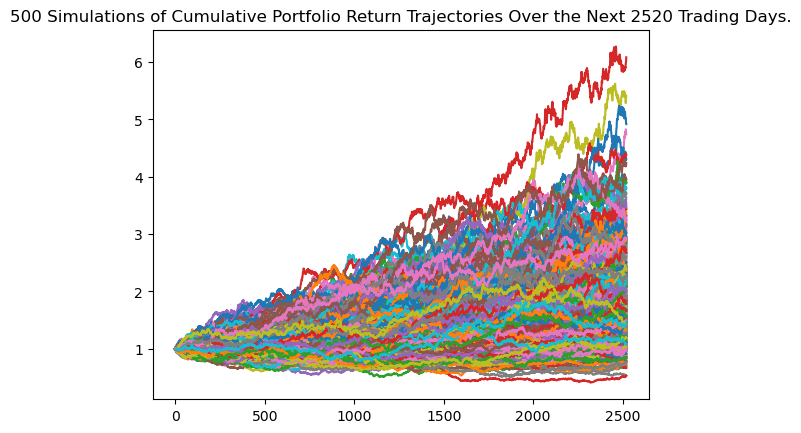

In [33]:
# Plot simulation outcomes
MC_10yr_early_cumret_line_plot = MC_10yr_early_cumret.plot_simulation()

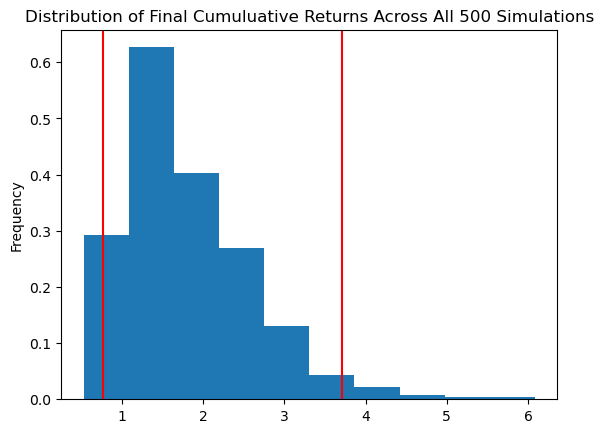

In [34]:
# Plot probability distribution and confidence intervals
MC_10yr_early_cumret_dist_plot = MC_10yr_early_cumret.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_10yr_early_cumret_tbl = MC_10yr_early_cumret.summarize_cumulative_return()

# Print summary statistics
MC_10yr_early_cumret_tbl

count           500.000000
mean              1.804566
std               0.778738
min               0.532312
25%               1.256141
50%               1.635680
75%               2.218680
max               6.084251
95% CI Lower      0.769885
95% CI Upper      3.712128
Name: 2520, dtype: float64

In [36]:
# Set initial investment
initial_investment = 30000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(MC_10yr_early_cumret_tbl[8]*initial_investment, 2)
ci_upper_ten = round(MC_10yr_early_cumret_tbl[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 10 years will end within in the range of $23096.54 and $111363.83


# Discussion

Confidence intervals improve with the length of the forecast. Since the forecasted value of our portfolio is directly proportional to the confidence interval and initial investment, it makes sense to improve the confidence interval as much as possible.

The weighting of our portfolio has the biggest impact on the confidence interval for a given timeframe. Varying the weights will be necessary to find the best retirement portfolio.

# Five and Ten Year Retirement Plan Trials

## The following is an addendum to the official Module 5 Challenge

Here we will find the investigate the best portfolio for 5- or 10-Year Retirement Plans. Let's loop over several different portfolio weightings to see which is optimal

In [37]:
# Define stock and bond weights in increments of 10%, not including 0% or 100%. The sum of each should always be 100%

stock_weight = [i/10 for i in list(range(1,10))]
bond_weight = stock_weight[::-1]
years_list = [5,10]

def mc_trials_by_years_and_weights(df_stock_data, bond_weight, stock_weight, years):
    TRADING_DAYS = 252
    # Create empty dataframe
    index_labels = ['Bond Weight', 'Stock Weight', 'CI Upper', 'CI Lower']
    m_index_labels = [f"{y} Year Forecast" for y in years_list] * len(index_labels)
    m_index_labels.sort(reverse=True)
    index_labels = index_labels * len(years_list)
    col_names = [f"Trial {i}" for i,w in enumerate(bond_weight, start=1)]
    results_df = pd.DataFrame(index=[m_index_labels,index_labels], columns=col_names)
    # Convert dataframe to dict to simplify reassigning values without hidden chaining issues
    results_dict = results_df.to_dict()
    for yr in years:
        for i, (bond_wt,stock_wt) in enumerate(zip(bond_weight, stock_weight), start=1):
            MC_trial_cumret = MCSimulation(
                portfolio_data=df_stock_data,
                weights=[bond_wt,stock_wt],
                num_simulation=500,
                num_trading_days= TRADING_DAYS*yr
            )
            MC_trial_cumret.calc_cumulative_return()
            MC_trial_tbl = MC_trial_cumret.summarize_cumulative_return()
            ci_upper = round(MC_trial_tbl[9],2)
            ci_lower = round(MC_trial_tbl[8],2)
            results_dict[f"Trial {i}"][(f"{yr} Year Forecast", 'Bond Weight')] = bond_wt
            results_dict[f"Trial {i}"][(f"{yr} Year Forecast", 'Stock Weight')] = stock_wt
            results_dict[f"Trial {i}"][(f"{yr} Year Forecast", 'CI Upper')] = ci_upper
            results_dict[f"Trial {i}"][(f"{yr} Year Forecast", 'CI Lower')] = ci_lower
    return pd.DataFrame(results_dict)

trial_results = mc_trials_by_years_and_weights(df_stock_data, bond_weight, stock_weight, years_list)
trial_results

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rafinazamodeen/Development/bootcamp/module5_financial_planning/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

Trial 1  Trial 2  Trial 3  Trial 4  Trial 5  \
5 Year Forecast  Bond Weight      0.90     0.80     0.70     0.60     0.50   
                 Stock Weight     0.10     0.20     0.30     0.40     0.50   
                 CI Upper         1.26     1.41     1.55     1.74     2.03   
                 CI Lower         0.80     0.81     0.79     0.75     0.75   
10 Year Forecast Bond Weight      0.90     0.80     0.70     0.60     0.50   
                 Stock Weight     0.10     0.20     0.30     0.40     0.50   
                 CI Upper         1.39     1.58     1.96     2.42     2.80   
                 CI Lower         0.69     0.79     0.77     0.77     0.73   

                               Trial 6  Trial 7  Trial 8  Trial 9  
5 Year Forecast  Bond Weight      0.40     0.30     0.20     0.10  
                 Stock Weight     0.60     0.70     0.80     0.90  
                 CI Upper         2.23     2.39     2.79     3.43  
                 CI Lower         0.69     0.73     0.61     0.61  
10 Year Forecast Bond Weight      0.40     0.30     0.20     0.10  
                 Stock Weight     0.60     0.70     0.80     0.90  
                 CI Upper         3.62     4.39     5.03     7.29  
                 CI Lower         0.74     0.72     0.69     0.64

#### Finding the highest return for 5- and 10-Year Retirement Plans

In [38]:
# Define a lambda function to extract the particular data we're seeking
data_max = lambda data,yr_lbl,idx_lbl2,idx_lbl : data[data.loc[yr_lbl, idx_lbl2].idxmax()][yr_lbl, idx_lbl]

# Get the data for weightings, and CI based on the largest CI (i.e. largest return) of all trials
bond_5yr_opt = data_max(trial_results, '5 Year Forecast', 'CI Upper', 'Bond Weight')
stock_5yr_opt = data_max(trial_results, '5 Year Forecast', 'CI Upper', 'Stock Weight')
ci_5yr_hi = data_max(trial_results, '5 Year Forecast', 'CI Upper', 'CI Upper')
ci_5yr_lo = data_max(trial_results, '5 Year Forecast', 'CI Upper', 'CI Lower')
bond_10yr_opt = data_max(trial_results, '10 Year Forecast', 'CI Upper', 'Bond Weight')
stock_10yr_opt = data_max(trial_results, '10 Year Forecast', 'CI Upper', 'Stock Weight')
ci_10yr_hi = data_max(trial_results, '10 Year Forecast', 'CI Upper', 'CI Upper')
ci_10yr_lo = data_max(trial_results, '10 Year Forecast', 'CI Upper', 'CI Lower')


print(f"The highest portfolio return for a 5-Year Retirement Plan occurs with a Bond to Stock ratio of {bond_5yr_opt}:{stock_5yr_opt}")
print(f"This results in a Upper Confidence Interval of {ci_5yr_hi} and a Lower Confidence Interval of {ci_5yr_lo}")
print(f"The highest portfolio return for a 10-Year Retirement Plan occurs with a Bond to Stock ratio of {bond_10yr_opt}:{stock_10yr_opt}")
print(f"This results in a Upper Confidence Interval of {ci_10yr_hi} and a Lower Confidence Interval of {ci_10yr_lo}")

The highest portfolio return for a 5-Year Retirement Plan occurs with a Bond to Stock ratio of 0.1:0.9
This results in a Upper Confidence Interval of 3.43 and a Lower Confidence Interval of 0.61
The highest portfolio return for a 10-Year Retirement Plan occurs with a Bond to Stock ratio of 0.1:0.9
This results in a Upper Confidence Interval of 7.29 and a Lower Confidence Interval of 0.64


#### Finding the lowest return for 5- and 10-Year Retirement Plans

In [39]:
# Define a lambda function to extract the particular data we're seeking
data_min = lambda data,yr_lbl,idx_lbl2,idx_lbl : data[data.loc[yr_lbl, idx_lbl2].idxmin()][yr_lbl, idx_lbl]

# Get the data for weightings, and CI based on the largest CI (i.e. largest return) of all trials
bond_5yr_opt_lo = data_min(trial_results, '5 Year Forecast', 'CI Lower', 'Bond Weight')
stock_5yr_opt_lo = data_min(trial_results, '5 Year Forecast', 'CI Lower', 'Stock Weight')
ci_5yr_hi_lo = data_min(trial_results, '5 Year Forecast', 'CI Lower', 'CI Upper')
ci_5yr_lo_lo = data_min(trial_results, '5 Year Forecast', 'CI Lower', 'CI Lower')
bond_10yr_opt_lo = data_min(trial_results, '10 Year Forecast', 'CI Lower', 'Bond Weight')
stock_10yr_opt_lo = data_min(trial_results, '10 Year Forecast', 'CI Lower', 'Stock Weight')
ci_10yr_hi_lo = data_min(trial_results, '10 Year Forecast', 'CI Lower', 'CI Upper')
ci_10yr_lo_lo = data_min(trial_results, '10 Year Forecast', 'CI Lower', 'CI Lower')


print(f"The lowest portfolio return for a 5-Year Retirement Plan occurs with a Bond to Stock ratio of {bond_5yr_opt_lo}:{stock_5yr_opt_lo}")
print(f"This results in a Upper Confidence Interval of {ci_5yr_hi_lo} and a Lower Confidence Interval of {ci_5yr_lo_lo}")
print(f"The lowest portfolio return for a 10-Year Retirement Plan occurs with a Bond to Stock ratio of {bond_10yr_opt_lo}:{stock_10yr_opt_lo}")
print(f"This results in a Upper Confidence Interval of {ci_10yr_hi_lo} and a Lower Confidence Interval of {ci_10yr_lo_lo}")

The lowest portfolio return for a 5-Year Retirement Plan occurs with a Bond to Stock ratio of 0.2:0.8
This results in a Upper Confidence Interval of 2.79 and a Lower Confidence Interval of 0.61
The lowest portfolio return for a 10-Year Retirement Plan occurs with a Bond to Stock ratio of 0.1:0.9
This results in a Upper Confidence Interval of 7.29 and a Lower Confidence Interval of 0.64


#### Discussion

The highest returns for both 5- and 10-Year retirement plans are found in the same trial (Trial 9) with a Bond-to-Stock ratio of 0.1:0.9. The lowest returns are found in the same and other trials but they are very close. This indicates that there is a wider spread of returns in this portfolio. How wide spread are the returns vs. other trials? Let's find out...

In [40]:
# First, find the percent differences between Upper and Lower CI across all trials
ci_5yr = pd.concat([trial_results.loc['5 Year Forecast', 'CI Lower'], trial_results.loc['5 Year Forecast', 'CI Upper']], axis='columns')
ci_5yr.T.pct_change()

Trial 1   Trial 2   Trial 3  Trial 4   Trial 5  \
5 Year Forecast CI Lower      NaN       NaN       NaN      NaN       NaN   
                CI Upper    0.575  0.740741  0.962025     1.32  1.706667   

                           Trial 6   Trial 7  Trial 8   Trial 9  
5 Year Forecast CI Lower       NaN       NaN      NaN       NaN  
                CI Upper  2.231884  2.273973  3.57377  4.622951

In [41]:
# Find the mean and standard deviation of the CI Lower data as in indication of its spread

ci_lo_5yr_avg = ci_5yr['5 Year Forecast']['CI Lower'].mean()
ci_lo_5yr_std = ci_5yr['5 Year Forecast']['CI Lower'].std()
print(f"""
5-Year Forecast Confidence Interval
-----------------------------------
Average:            {ci_lo_5yr_avg:.2f}
Standard Deviation: {ci_lo_5yr_std:.2f}
""")


5-Year Forecast Confidence Interval
-----------------------------------
Average:            0.73
Standard Deviation: 0.08



In [42]:
# Find the percent differences of Upper and Lower CI between all trials
ci_5yr.pct_change()

5 Year Forecast          
               CI Lower  CI Upper
Trial 1             NaN       NaN
Trial 2        0.012500  0.119048
Trial 3       -0.024691  0.099291
Trial 4       -0.050633  0.122581
Trial 5        0.000000  0.166667
Trial 6       -0.080000  0.098522
Trial 7        0.057971  0.071749
Trial 8       -0.164384  0.167364
Trial 9        0.000000  0.229391

In [43]:
# Repeat the steps above, for the 10-Year Retirement data
ci_10yr = pd.concat([trial_results.loc['10 Year Forecast', 'CI Lower'], trial_results.loc['10 Year Forecast', 'CI Upper']], axis='columns')
ci_10yr.T.pct_change()

Trial 1  Trial 2   Trial 3   Trial 4   Trial 5  \
10 Year Forecast CI Lower       NaN      NaN       NaN       NaN       NaN   
                 CI Upper  1.014493      1.0  1.545455  2.142857  2.835616   

                            Trial 6   Trial 7   Trial 8    Trial 9  
10 Year Forecast CI Lower       NaN       NaN       NaN        NaN  
                 CI Upper  3.891892  5.097222  6.289855  10.390625

In [44]:
ci_lo_10yr_avg = ci_10yr['10 Year Forecast']['CI Lower'].mean()
ci_lo_10yr_std = ci_10yr['10 Year Forecast']['CI Lower'].std()
print(f"""
5-Year Forecast Confidence Interval
-----------------------------------
Average:            {ci_lo_10yr_avg:.2f}
Standard Deviation: {ci_lo_10yr_std:.2f}
""")


5-Year Forecast Confidence Interval
-----------------------------------
Average:            0.73
Standard Deviation: 0.05



In [45]:
ci_10yr.pct_change()

10 Year Forecast          
                CI Lower  CI Upper
Trial 1              NaN       NaN
Trial 2         0.144928  0.136691
Trial 3        -0.025316  0.240506
Trial 4         0.000000  0.234694
Trial 5        -0.051948  0.157025
Trial 6         0.013699  0.292857
Trial 7        -0.027027  0.212707
Trial 8        -0.041667  0.145786
Trial 9        -0.072464  0.449304

In [46]:
# Check what an initial investment of $30k would produce for both 5- and 10-Year retirement plans

initial_investment = 30000
ci_lower_5yr = round(ci_5yr_lo * initial_investment, 2)
ci_upper_5yr = round(ci_5yr_hi * initial_investment, 2)
ci_lower_10yr = round(ci_10yr_lo * initial_investment, 2)
ci_upper_10yr = round(ci_10yr_hi * initial_investment, 2)

print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5yr} and ${ci_upper_5yr}")

print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_10yr} and ${ci_upper_10yr}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 5 years will end within in the range of $18300.0 and $102900.0
There is a 95% chance that an initial investment of $30000 in the portfolio over the next 10 years will end within in the range of $19200.0 and $218700.0


# Conclusion

Investing is always a longterm strategy and any other 'quick' strategy will come with higher risks. The early retirement plan that provides the highest possible ROI for both 5- and 10-Years has a stock-to-bond ratio of 0.9:0.1. However, this comes with risks because they could also provide the lowest possible returns. The highest yielding portfolios also have the largest spread.

Looking at the data above, we can make decisions about the best portfolio for both 5- and 10-Year plans. The percent differences of the Lower Confidence Intervals for the 5-Year Plan are all lower than 10% across all trials, except Trial 8. However, for the 10-Year plan there is only 1 Lower Confidence Interval that is above 10% (Trial 2). The standard deviations of the Lower CI for both 5- and 10-Year plans are small relative to the actual data and their means (averages). As a result, I would recommend an investor interested in a 5- or 10-Year retirement plan to invest in the portfolio with a stock-to-bond ratio of 0.9:0.1.